# Analyse channel 1 - 4
Various plots and analyses of channels 1 to 4 from Alsdorf.
Highlights are histogram of water tank difference, difference to PTSal log from 24.11.2020, length dependent difference between channels.


In [16]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn")
import numpy as np
import matplotlib.dates as mdates
from scipy import optimize
import matplotlib.patches as patches
from collections import defaultdict
from datetime import timedelta
from datetime import datetime
import pickle
from copy import deepcopy#, copy
import statistics
from bokeh.io import export_png, export_svgs
from bokeh.models import ColumnDataSource, DataTable, TableColumn
from shutil import copy2 as copy_file
from scipy.stats import norm

import plotly
import plotly.express as px
import kaleido
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from my_func_mvw.functions_import_my_database import import_my_database_pickle, import_my_database_csv, merge_data_year, import_tlogger
from my_func_mvw.functions import find_nearest_date, calc_diff_between_channels, read_pickle, write_pickle, temp_watertank_func, calc_stat_of_difference, carpet_plot_with_gaps, add_nan_val_in_datagaps, statistic_plot, plot_water_rise
from my_func_mvw.fourier_transform_func import resample_data_func, plot_frequency_spectrum, fourier_transform
from my_func_mvw.functions_dts_processing import watertank_shift, check_first_last_date, cut_dataframe_to_range_tlogger, check_processed_data, diff_to_watertank
%load_ext autoreload
%autoreload 2

plot_save=True #True False
masterthesis_save=False #True False
fast_calc=False #True False
show_large_plot=True #True False

path_DTS_processed = r"..\Alsdorf\Daten\DTS_processed"
importer = "pickle" #at the moment everything is imported with pickle

print("Some Version information of the imported packages")
print(f"pandas version: {pd.__version__}")
print(f"pickle version: {pickle.format_version}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Some Version information of the imported packages
pandas version: 1.3.4
pickle version: 4.0


In [17]:
# Load pickle Data
data_ch14_constshifted = read_pickle(path_DTS_processed + "\import_data_scripts\data_ch1-4_processed_constshifted") #if using all data this variable is over 2Gb.

if fast_calc:
    for chan in ["1","2","3","4"]:
        data_ch14_constshifted[chan] = data_ch14_constshifted[chan][::10] #only use every 10th row

# final shaft temp old cable
shaft={}
for chan in ["1","2","3","4"]:
    shaft[chan] = read_pickle(path_DTS_processed + f"\\shaft_temperatures\\old_cable\\pickle\\Schacht_chan_{chan}")

# final shaft temp egrt cabel
filename=f"\\Schacht_7and8_down"
Schacht_7and8_down = read_pickle(path_DTS_processed + r"\shaft_temperatures\egrt_cable\pickle" + filename)


In [18]:
# Import TLogger
df_Tlogger, df_Tlogger_PT1000 = import_tlogger(path_DTS_processed=path_DTS_processed,importer=importer)
watertank_T_range_min = df_Tlogger.index.min()
watertank_T_range_max = df_Tlogger.index.max()

df_Tlogger

,Channel1-Watertank,Channel2-Air,Channel1_rolling_mean
2021-06-07 12:12:40,23.4,25.8,23.5
2021-06-07 12:13:40,23.5,25.4,23.5
2021-06-07 12:14:40,23.4,25.2,23.5
2021-06-07 12:15:40,23.5,24.9,23.5
2021-06-07 12:16:40,23.5,24.8,23.5
...,...,...,...
2021-10-06 10:49:47,17.7,NaN,17.7
2021-10-06 10:52:47,17.7,NaN,17.7
2021-10-06 10:55:47,17.7,NaN,17.7
2021-10-06 10:58:47,17.7,NaN,17.7


In [19]:
# calc diff to watertank
watertank_diff_log_data_all=diff_to_watertank(cut_dataframe_to_range_tlogger(["1","2","3","4"],data_ch14_constshifted,watertank_T_range_min,watertank_T_range_max),
                                        df_Tlogger=df_Tlogger,watertank_len=[71],watertank_T_range_min=watertank_T_range_min,watertank_T_range_max=watertank_T_range_max)


Channel: 1; Number of dates: 5554
first (oldest) date: 2021-06-07 12:12:22
last (newest) date: 2021-10-06 10:14:50

Channel: 2; Number of dates: 5554
first (oldest) date: 2021-06-07 12:16:22
last (newest) date: 2021-10-06 10:18:50

Channel: 3; Number of dates: 5554
first (oldest) date: 2021-06-07 12:20:22
last (newest) date: 2021-10-06 10:22:50

Channel: 4; Number of dates: 5554
first (oldest) date: 2021-06-07 12:24:22
last (newest) date: 2021-10-06 10:26:50


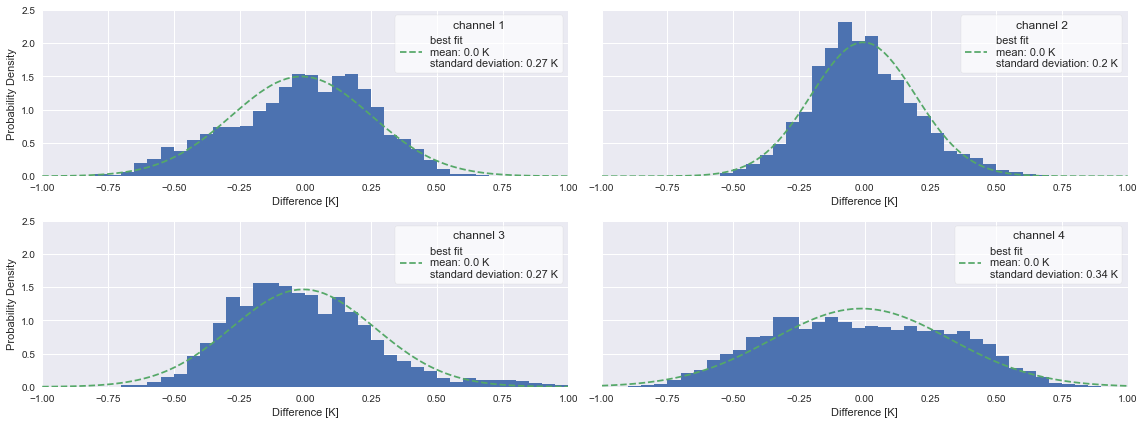

In [20]:
#differenced at first watertank position of processed data to reference temp
def plt_hist_in_axs(data,ax,num_bins=30,binwidth=0.05):
    """"""
    mean=data.mean()
    stdv=data.std()

    # n, bins, patches = ax.hist(data, num_bins, density=True) #uses number of bins
    n, bins, patches = ax.hist(data,bins=np.arange(-1, 1 + binwidth, binwidth), density=True) #uses a binwidth
    from scipy.stats import norm
    x = np.linspace(-1, 1, 100)
    ax.plot(x, norm.pdf(x, mean, stdv),linestyle="--",label=f"best fit\nmean: 0.0 K\nstandard deviation: {round(stdv,2)} K")

    #Alternative plotting ways:
    # weights = np.ones_like(data)/float(len(data))
    # n, bins, patches =ax.hist(data, weights=weights)

    # y=((1 / (np.sqrt(2 * np.pi) * stdv)) * np.exp(-0.5 * (1 / stdv * (bins - mean))**2)) #best fit
    # ax.plot(bins, y, '--', label=f"best fit\nmean: 0.0 °C\nstandard deviation: {round(stdv,2)} K")

fig,axs=plt.subplots(2,2,figsize=(16,6),sharey=True,tight_layout=True)
axes_tuples=[[0,0],[0,1],[1,0],[1,1]]
axes_counter=0
for chan in ["1","2","3","4"]:
    ax=axs[axes_tuples[axes_counter][0]][axes_tuples[axes_counter][1]]
    plt_hist_in_axs(watertank_diff_log_data_all[chan].loc[71],ax)

    # Acessoirs
    legend=ax.legend(fontsize=11, frameon=True,title_fontsize=12,title=f"channel {chan}")
    legend.get_frame().set_alpha(0.7) #not supported with eps
    legend.get_frame().set_facecolor("white")
    ax.set_ylim(0,2.5)
    ax.set_xlim(-1,1)
    ax.set_xlabel("Difference [K]")
    axes_counter+=1

axs[0,0].set_ylabel("Probability Density")
axs[1,0].set_ylabel("Probability Density")

if plot_save:
    plt.savefig("pictures\diff_to_first_watertanl_probability_ch14.png",bbox_inches="tight")
    if masterthesis_save:
        plt.savefig(r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\figs\chap4\diff_to_first_watertanl_probability_ch14.pdf", format="pdf",bbox_inches="tight")
        plt.savefig(r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\figs_raster\chap4\diff_to_first_watertanl_probability_ch14.png", format="png",bbox_inches="tight",dpi=300)
plt.show()

In [21]:
# difference between the channels has a higher standard deviation than the difference to the reference temperature
show_diff_in_watertank_between_channels=False
if show_diff_in_watertank_between_channels:
    test=cut_dataframe_to_range_tlogger(["1","2","3","4"],data_ch14_constshifted,watertank_T_range_min,watertank_T_range_max)
    test_diff=test["1"][71].values - test["4"][71].values

    binwidth=0.05
    n, bins, patches = plt.hist(test_diff,bins=np.arange(-1, 1 + binwidth, binwidth), density=True) #uses a binwidth
    mean=test_diff.mean()
    stdv=test_diff.std()
    
    x = np.linspace(-1, 1, 100)
    plt.plot(x, norm.pdf(x, mean, stdv),linestyle="--",label=f"best fit\nmean: 0.0 °C\nstandard deviation: {round(stdv,2)} K")
    plt.legend()
    plt.show()

# Compare BHE Cable channel 1 - 4 to Wireline T-Logger 2020

In [22]:
# Load Wireline data
path_to_wireline = path_DTS_processed + "\..\PTS_Logs"

filename2003=r"\PTS_2003.csv"
wireline_measurements2003 = pd.read_csv(path_to_wireline + filename2003,skiprows=[0,2,3],index_col=0,na_values=-999.0)
wireline_measurements2003.columns = ["BHT","CBLE_ACC","CURRENT","DIFF-TENSION0","GAMMA","MEASURERANGE","PRESS","SAL","SPEED","TENSION","TIME","VOLTAGE"] #rename columns, because the original names contain empty spaces
wireline_measurements2003 = wireline_measurements2003.dropna()

filename2020=r"\PTS_20201124.csv"
wireline_measurements2020 = pd.read_csv(path_to_wireline + filename2020,index_col=0,skiprows=[0,2,3],na_values=-999.0)
wireline_measurements2020.columns = ["BHT","DEPTH.1","dPress","GAMMA","MEASURERANGE","PRESS","SAL","SPEED","TENSION","TIME"]
wireline_measurements2020 = wireline_measurements2020.drop(columns=["DEPTH.1"]) # the same as DEPTH column
wireline_measurements2020 = wireline_measurements2020.dropna() # drop some nan rows

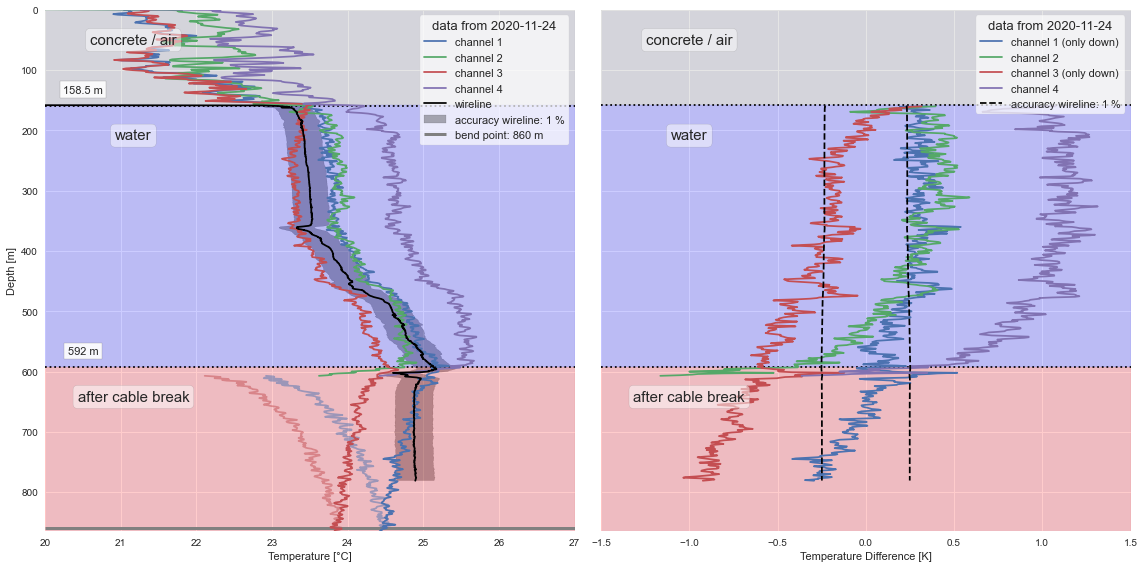

mean diff to wireline
1: 0.164
2: 0.202
3: -0.402
4: 0.971


In [23]:
## INPUT #########
average_multiple_data=6 #number of dates to average; 0 for no averageing; e.g. 5 results in average of 11 dates
border_dts_not_trusted=592
string_dts_not_trusted="after cable break"
#############
begin_shaft = 200 #used also in other cells

################# Calc diff to wireline
diff_to_wireline = {}
# Create Dataframe for results
wireline_shortend = wireline_measurements2020["BHT"][160:][::20] #skip air, only use datapoints every meter
last_wireline_depth=wireline_shortend.index.max()
shaft_data = pd.DataFrame(index=np.arange(160,last_wireline_depth+1,1),columns=["dts chan 1","dts chan 2","dts chan 3","dts chan 4","wireline"])
shaft_data.index.names=["Depth"]

shaft_data["wireline"] = wireline_shortend.values
for chan in ["1","2","3","4"]:
    date_name, date_iloc = find_nearest_date("2020-11-24 12:00:00",data_ch14_constshifted[chan].index)
    # print(date_iloc)
    if average_multiple_data!=0:
        ilocs=np.arange(date_iloc-average_multiple_data,date_iloc+average_multiple_data+1,1)
    
    if chan in ["1","3"]:
        if average_multiple_data==0:
            data_ch = data_ch14_constshifted[chan].loc[date_name][begin_shaft+160: int(last_wireline_depth)+201] #skip first 200 and air
        elif average_multiple_data!=0:
            data_ch=pd.concat([data_ch14_constshifted[chan].iloc[x][begin_shaft+160: int(last_wireline_depth)+201] for x in ilocs], axis=1).mean(axis=1).round(2)
        shaft_data[f"dts chan {chan}"]= data_ch.values
    
    elif chan in ["2","4"]:
        index=data_ch14_constshifted[chan].loc[date_name][begin_shaft+160:].index-begin_shaft #index shifted to shaft
        nanarray=np.empty((int(last_wireline_depth-index.max())))
        nanarray[:]=np.nan
        if average_multiple_data==0:
            data_ch=np.append(data_ch14_constshifted[chan].loc[date_name][begin_shaft+160:],nanarray) #skip first 200 and air; add nan so length fits to wireline
        elif average_multiple_data!=0:
            data_ch=pd.concat([data_ch14_constshifted[chan].iloc[x][begin_shaft+160:] for x in ilocs], axis=1).mean(axis=1).round(2)
            data_ch=np.append(data_ch.values,nanarray)
        shaft_data[f"dts chan {chan}"] = data_ch

    diff_to_wireline[chan] = shaft_data[f"dts chan {chan}"] - shaft_data["wireline"]

########### PLOT: compare shifted data to wireline
def color_cable_pos(start_len, end_len, col, ymax, ymin, label_name, axs, label=True):
    """ creates patches which color the plot
    I slightly adapt this for every notebook"""
    width = end_len - start_len
    Rectangle=patches.Rectangle(xy=[start_len,ymin],width=width,height=(ymax-ymin),color=col,alpha=0.2)
    axs.add_patch(Rectangle)
    if label:
        #axs.annotate(label_name,[start_len+width/2, ymax-(ymax-ymin)*0.9],size=15)
        bbox_props=dict(boxstyle="round",fc="white", ec="0.5", alpha=0.5)
        axs.text(start_len+width/6,ymin+50,label_name,ha="center",va="center",size=15,bbox=bbox_props)

water_table_depth=158.5
fig, axs = plt.subplots(1,2,figsize=[16,8],sharey=True,tight_layout=True)

#######################################1st axes##############################################
for chan in ["1","2","3","4"]: # Plot DTS channel temperature
    date_name, date_iloc = find_nearest_date("2020-11-24 12:00:00",data_ch14_constshifted[chan].index)
    if average_multiple_data==0:
        data=data_ch14_constshifted[chan].loc[date_name]
    elif average_multiple_data!=0:
        ilocs=np.arange(date_iloc-average_multiple_data,date_iloc+average_multiple_data+1,1)
        data= pd.concat([data_ch14_constshifted[chan].iloc[x] for x in ilocs], axis=1).mean(axis=1).round(2)
    templine,=axs[0].plot(data.values, data.index - begin_shaft,
                label=f"channel {chan}") #\nTime: {date_name[11:-3]}

    # plot channels 1 and 3 at bend point back so they fit to shaft depth
    if chan in ["1","3"]:
        bend_p=begin_shaft + 860
        data_after_bendpoint = data[bend_p:]
        new_index=np.arange(bend_p,bend_p-len(data_after_bendpoint.index),-1)
        data_after_bendpoint.index = new_index
        axs[0].plot(data_after_bendpoint.values, data_after_bendpoint.index - begin_shaft,color=templine.get_color(), alpha=0.5)

# Plot wireline temperautre
axs[0].plot(wireline_measurements2020["BHT"].values, wireline_measurements2020["BHT"].index,label="wireline",color="black")
data=wireline_measurements2020["BHT"][::20] #original dataframe has every 5 cm a datapoint, 1 m is sufficient
axs[0].fill_betweenx(data.index,data.values+0.01*data.values,data.values-0.01*data.values,color="black",alpha=0.3, 
                    label="accuracy wireline: 1 %")

# Assecoirs
templim=[20,27]
axs[0].hlines([160,border_dts_not_trusted],templim[0],templim[1],color="black",linestyle=":")
bbox_props = dict(boxstyle="square", fc="w", ec="0.5", alpha=0.9)
size=11; y=50; ha="center"; va="center"
axs[0].text(templim[0]+0.5,border_dts_not_trusted -26,f"{border_dts_not_trusted} m", ha=ha, va=va, size=size, bbox=bbox_props)
axs[0].text(templim[0]+0.5,water_table_depth -26,"158.5 m", ha=ha, va=va, size=size, bbox=bbox_props)
color_cable_pos(templim[0],templim[1],"red",1150,border_dts_not_trusted,f"{string_dts_not_trusted}",axs[0])
color_cable_pos(templim[0],templim[1],"gray",water_table_depth,0,"concrete / air",axs[0])
color_cable_pos(templim[0],templim[1],"blue",border_dts_not_trusted,water_table_depth,"water",axs[0])
#axs[0].set_title("Wireline 2020 and Corrected DTS", fontsize = 14)
axs[0].set_xlabel("Temperature [°C]")
axs[0].set_xlim(templim)
axs[0].set_ylabel("Depth [m]")
# Bend point
last_length={}
for channel in ["1","2","3","4"]:
    col=data_ch14_constshifted[channel].columns[begin_shaft:]
    last_length[channel] = data_ch14_constshifted[channel][col].columns.max() - begin_shaft
    #print(f"Channel {channel} shifted, last length {last_length[channel]}")
bend_point=last_length["2"] + (last_length["1"] - last_length["2"]) / 2 #also used in following cells; passt ziemlich genau zur Einbautiefe der Erdwärmesonde
axs[0].hlines([bend_point],templim[0],templim[1],color="grey",label=f"bend point: {int(bend_point)} m", linewidth=3)

#######################################2nd axes##############################################
for chan in ["1","2","3","4"]: #plot differences
    label_addon=""
    if chan in ["1","3"]:
        label_addon=" (only down)"
    axs[1].plot(diff_to_wireline[chan].values,diff_to_wireline[chan].index,label=f"channel {chan}{label_addon}")
# Plot accuracy wireline
data=wireline_measurements2020["BHT"][::20][water_table_depth:]
axs[1].plot(0.01*data.values,data.index,color="black",linestyle="--", label="accuracy wireline: 1 %")
axs[1].plot(-0.01*data.values,data.index,color="black",linestyle="--")

# Assecoirs
difflim=[-1.5,1.5]
axs[1].hlines([water_table_depth,border_dts_not_trusted],difflim[0],difflim[1],color="black",linestyle=":") #0
color_cable_pos(difflim[0],difflim[1],"red",1150,border_dts_not_trusted,f"{string_dts_not_trusted}",axs[1])
color_cable_pos(difflim[0],difflim[1],"gray",water_table_depth,0,"concrete / air",axs[1])
color_cable_pos(difflim[0],difflim[1],"blue",border_dts_not_trusted,water_table_depth,"water",axs[1])
#axs[1].set_title("Difference DTS - Wireline", fontsize = 14)
axs[1].set_xlabel("Temperature Difference [K]")
axs[1].set_xlim(difflim)

#####Assecoirs both axes
for ax in axs:
    ax.set_ylim([bend_point+4,0]) # -200
    fonts=11
    legend = ax.legend(fontsize=fonts,title="data from 2020-11-24", title_fontsize=fonts+2, frameon=True, loc="upper right")
    legend.get_frame().set_alpha(0.7)
    legend.get_frame().set_facecolor("white")

if plot_save:
    plt.savefig("pictures\compare_wireline2020.png",bbox_inches="tight")
    if masterthesis_save:
        plt.savefig(r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\figs\chap4\compare_wireline2020.pdf", format="pdf",bbox_inches="tight")
        plt.savefig(r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\figs_raster\chap4\compare_wireline2020.png", format="png",bbox_inches="tight",dpi=300)
plt.show()

print("mean diff to wireline")
for chan in ["1","2","3","4"]:
    mean_diff_ch=diff_to_wireline[chan].mean()
    print(f"{chan}: {round(mean_diff_ch,3)}")

In [24]:
# find depth of water level from wireline log
show_this_plot=False
if show_this_plot:
    (wireline_measurements2020["SAL"]+20).plot(label="salinity",color="blue") 
    wireline_measurements2020["BHT"].plot(color="red")
    plt.vlines([159],8,25)
    plt.show()

    wireline_measurements2020["SAL"][156:159].plot() # water depth 158.5
    plt.show()

## Plot Shaft Temperature

Channel 1 shifted, last length 1113
Channel 2 shifted, last length 607
Channel 3 shifted, last length 1114
Channel 4 shifted, last length 607
bend point is at 860.0, if assuming the DTS measurements exactly stop at the fibre break
die werte  passen nicht zu S. 48 im Abschlussbericht, da war das DTS Gerät irgendwie anders angeschlossen?


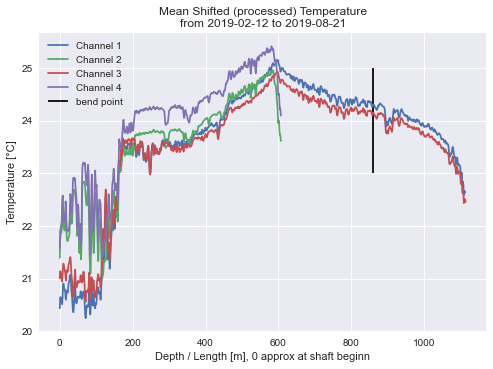

In [25]:
data={}
for channel in ["1","2","3","4"]: # shorten dates
    data[channel]=data_ch14_constshifted[channel][:15000] #[40000:48000]
# print maximum length of channel
last_length={}
for channel in ["1","2","3","4"]:
    last_length[channel] = data[channel][data[channel].columns[begin_shaft:]].columns.max() - begin_shaft
    print(f"Channel {channel} shifted, last length {last_length[channel]}")
# plot dts temp
for channel in ["1","2","3","4"]:
    y=data[channel][data[channel].columns[begin_shaft:]].mean(axis=0).values
    x=data[channel][data[channel].columns[begin_shaft:]].mean(axis=0).index - begin_shaft
    plt.plot(x,y, label=f"Channel {channel}")

# Assecoirs
plt.vlines([bend_point],23,25,color="black",label="bend point")
plt.legend()
min_date=data[channel][data[channel].columns[begin_shaft:]].index.min().strftime("%Y-%m-%d")
max_date=data[channel][data[channel].columns[begin_shaft:]].index.max().strftime("%Y-%m-%d")
plt.title(f"Mean Shifted (processed) Temperature\nfrom {min_date} to {max_date}")
plt.xlabel("Depth / Length [m], 0 approx at shaft beginn")
plt.ylabel("Temperature [°C]")
#plt.xlim(begin_shaft,400)

print(f"bend point is at {bend_point}, if assuming the DTS measurements exactly stop at the fibre break")
print("die werte  passen nicht zu S. 48 im Abschlussbericht, da war das DTS Gerät irgendwie anders angeschlossen?")
plt.show()

In [26]:
if show_large_plot:
    c="4"
    plt_length_begin=200
    data=data_ch14_constshifted[c][data_ch14_constshifted[c].columns[plt_length_begin:]][::10]
    data.columns=data.columns-begin_shaft
    data.columns.names=[f"Length - {begin_shaft} m"]

    plot=px.imshow(data, labels={"color":"Temperature"}, title=f"Channel {c}\nTemp. over time; every date plotted",
                zmin=22,zmax=25)
    # exports the plot as html, so the hover features are avaible: #https://plotly.com/python/static-image-export/
    path = r".\pictures"
    # filename = "\carpet_final_temperature_EGRT-Cable_down.png"
    # plot.write_image(path + filename)
    filename = f"\\analyse_bendpoint_ch{c}.html"
    plotly.offline.plot(plot, filename=path + filename)

2
7234 dates with nan have been added


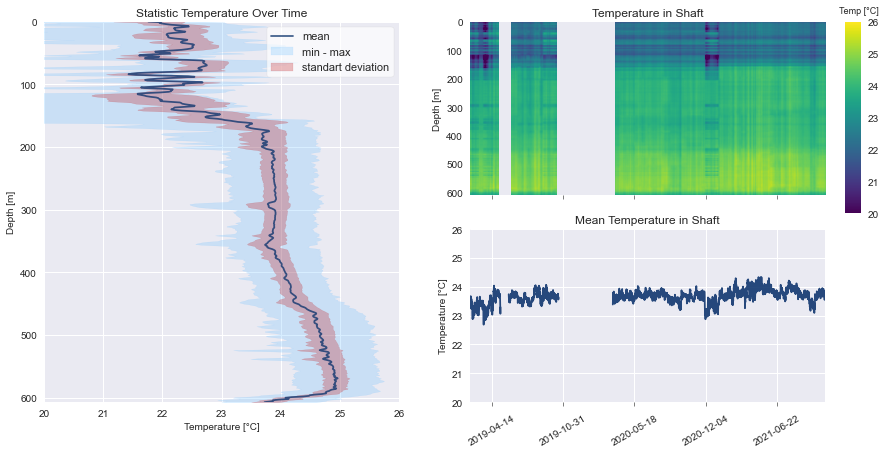

In [27]:
# Overview plot temp over time, similar plot as from Daniel
channel="2" #change me
print(f"{channel}")
statistic_plot(data_shaft=shaft,date_min_max=[0,-1],c=channel,temp_ax_min=20, temp_ax_max=26, sample_hours = 6)

if plot_save and channel == "2":
    filename=f"\\temperature_in_shaft_chan{channel}_statistic"
    plt.savefig(r".\pictures" + filename + ".png", bbox_inches="tight")
    if masterthesis_save:
        plt.savefig(r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\figs\chap4" + filename + ".pdf", format="pdf",bbox_inches="tight")
        plt.savefig(r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\figs_raster\chap4" + filename + ".png", format="png",bbox_inches="tight",dpi=300)
plt.show()

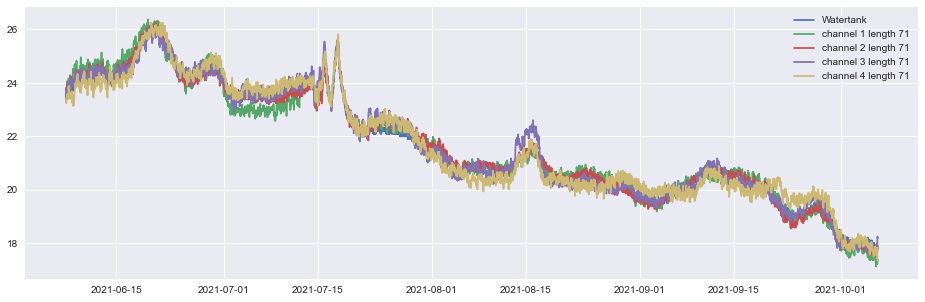

In [28]:
# Compare watertank to channels
watertank = 71 

plt.figure(figsize=(16,5))
plt.plot(df_Tlogger.index, df_Tlogger["Channel1-Watertank"], label="Watertank")
#plt.plot(df_Tlogger.index, df_Tlogger["Channel2-Air"], label="Air")
for c in ["1","2","3","4"]: 
    inde=data_ch14_constshifted[c][str(df_Tlogger.index.min()) : str(df_Tlogger.index.max())][watertank].index
    val=data_ch14_constshifted[c][str(df_Tlogger.index.min()) : str(df_Tlogger.index.max())][watertank].values
    plt.plot(inde,val, label=f"channel {c} length {watertank}")

plt.legend()
plt.show()

# Compare Varianz of constshift data
``compare_ch14_to_heatexchanger_usage.ipynb`` directly compares the heat exchnager usage and the data

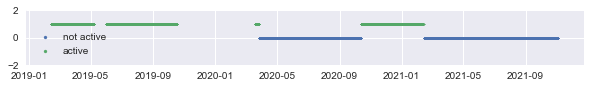

In [29]:
# Define when heat pump was active

# these vales are always outside the active phase
# tab for not active: first activ phase 0 to 21000
active_border=[0,21000,    39000,50000] # relativ grob

# Divide DTS data for active and not active
data_ch14_constshifted_heatpump_active = {}
for chan in ["1","2","3","4"]:
    index1=data_ch14_constshifted[chan].index[:active_border[1]]
    index2=data_ch14_constshifted[chan].index[active_border[2]+1:active_border[3]]
    index_heatpumpactive=index1.append(index2)
    data_ch14_constshifted_heatpump_active[chan] = data_ch14_constshifted[chan].loc[index_heatpumpactive]

data_ch14_constshifted_heatpump_notactive = {}
for chan in ["1","2","3","4"]:
    index1=data_ch14_constshifted[chan].index[active_border[1]:active_border[2]+1]
    index2=data_ch14_constshifted[chan].index[active_border[3]:]
    index_heatpumpnotactive=index1.append(index2)
    data_ch14_constshifted_heatpump_notactive[chan] = data_ch14_constshifted[chan].loc[index_heatpumpnotactive]

plt.figure(figsize=(10,1))
plt.ylim(-2,2)
plt.scatter(index_heatpumpnotactive,np.zeros(len(index_heatpumpnotactive)),s=1,label="not active")
plt.scatter(index_heatpumpactive,np.ones(len(index_heatpumpactive)),s=1, label="active")
legend=plt.legend()
for handle in legend.legendHandles:
    handle.set_sizes([9])
plt.show()

In [30]:
def calc_statistic_of_channel_difference(data):
    """"""
    df_reindex={}
    df_reindex["1"]=data["1"]
    for chan in ["2","3","4"]:
        df_reindex[chan]=data[chan].set_index(data["1"].index)

    diff={}; mean={}; std={}
    for chan_diff_pair in [["1","2"],["1","3"],["1","4"],["3","2"],["4","2"],["3","4"]]:
        chanx=chan_diff_pair[0]
        chany=chan_diff_pair[1]
        diff[f"{chanx} - {chany}"]=df_reindex[chanx] - df_reindex[chany]
        mean[f"{chanx} - {chany}"]=diff[f"{chanx} - {chany}"].mean(axis=0) #mean along columns (length)
        std[f"{chanx} - {chany}"]=diff[f"{chanx} - {chany}"].std(axis=0)

    number_dates_used = len(diff[f"{chanx} - {chany}"].index)

    mean["all"]=pd.concat([mean[x] for x in mean.keys()], axis=1).mean(axis=1) # mean of all differences 
    std["all"]=pd.concat([std[x] for x in std.keys()], axis=1).mean(axis=1) # mean standart deviation of all differences
    return mean, std, number_dates_used

# print("mean_constshift")
mean_constshift, std_constshift, number_dates_used = calc_statistic_of_channel_difference(data_ch14_constshifted)
# print("mean_constshift_heatpumpactive")
mean_constshift_heatpumpactive, std_constshift_heatpumpactive, number_dates_used_heatpumpactive = calc_statistic_of_channel_difference(data_ch14_constshifted_heatpump_active)
# print("mean_constshift_heatupumnotactive")
mean_constshift_heatpumpnotactive, std_constshift_heatpumpnotactive, number_dates_used_heatpumpnotactive = calc_statistic_of_channel_difference(data_ch14_constshifted_heatpump_notactive)
# print("mean_raw") #does not show anything new
# mean_raw, std_raw, number_dates_used_raw = calc_statistic_of_channel_difference(data_ch14_processed_withoutTlogger) #variable not in this script

In [31]:
# Peaks are at month 05 even when heat exchanger is off
#--> when heat exchanger is not extracting power it sometime circluates the water in the BHE very slow

# # these plots are garbage o.O
# data1=data_ch14_constshifted_heatpump_notactive["2"]
# col=data1.columns
# data2=data_ch14_constshifted_heatpump_notactive["3"][col]
# testdiff=data1.set_index(data2.index)-data2
# col=testdiff.columns[300:]
# testdiff[col].mean(axis=1).plot()
# plt.ylim(-0.5,2)
# plt.show()

# data1=data_ch14_constshifted_heatpump_notactive["2"]
# col=data1.columns
# data2=data_ch14_constshifted_heatpump_notactive["3"][col]
# testdiff=data1.set_index(data2.index)-data2
# col=testdiff.columns[80:150]
# testdiff[col].mean(axis=1).plot()
# plt.ylim(-0.5,2)
# plt.show()

all dates


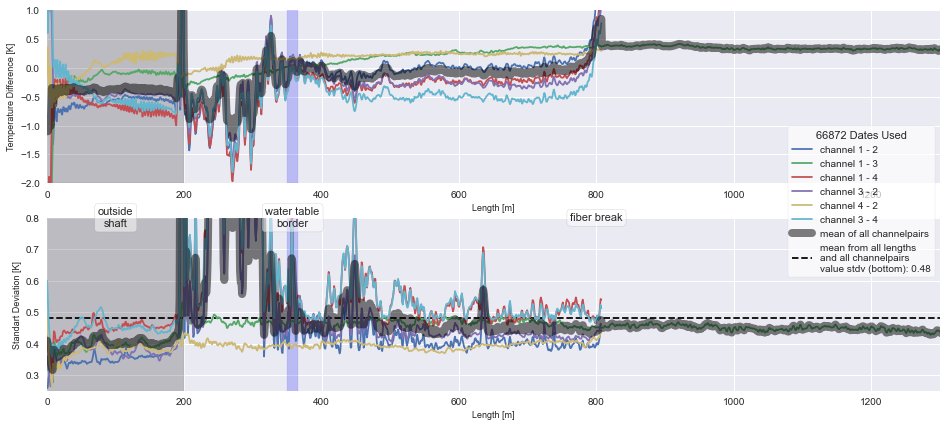

heatpump not active


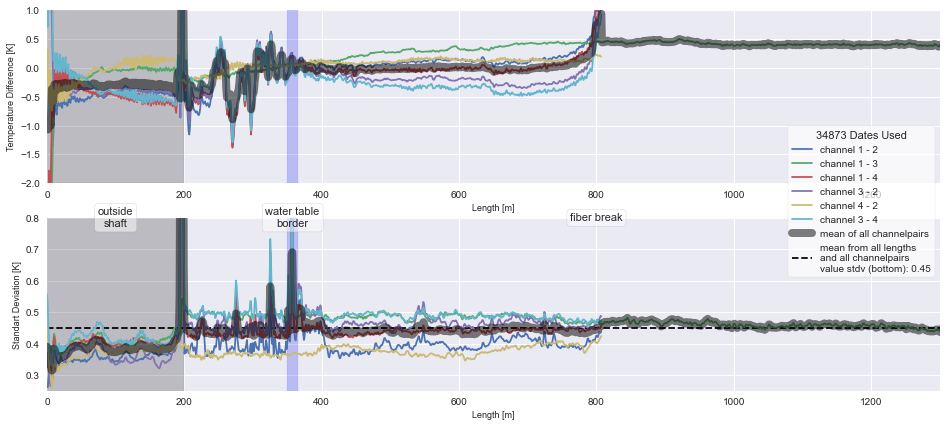

heatpump active


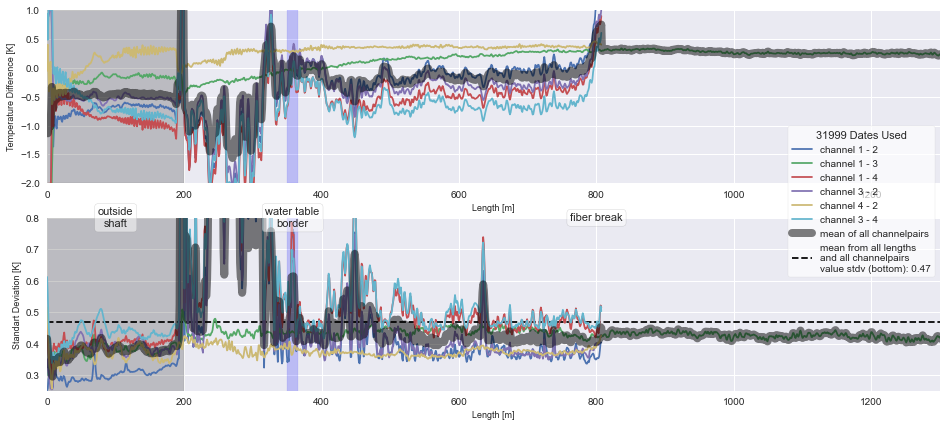

In [32]:
def plot_statistic_of_channel_difference(mean, std, number_dates_used_string, ylim=[-2,1.0], ax1ylim=[0.25,0.8],diff_plot=False):
    """"""
    fig, axs=plt.subplots(2,1,figsize=[16,7])
    for chan_diff_pair in [["1","2"],["1","3"],["1","4"],["3","2"],["4","2"],["3","4"]]: #plot difference between channels
        chanx=chan_diff_pair[0]
        chany=chan_diff_pair[1]
        axs[0].plot(mean[f"{chanx} - {chany}"], label=f"channel {chanx} - {chany}")
        axs[1].plot(std[f"{chanx} - {chany}"], label=f"channel {chanx} - {chany}")
    axs[0].plot(mean["all"], label="mean of all channelpairs", linewidth=8, alpha=0.5, color="black") # plot mean diff of all
    axs[1].plot(std["all"], label="mean of all channelpairs", linewidth=8, alpha=0.5, color="black") #mean std of all

    if diff_plot==False: # plot horizontal mean line if not in diff_plot
        hline_val_stdv=round(std["all"].mean(),2)
        axs[1].hlines([hline_val_stdv],std["all"].index.min(),std["all"].index.max(),
                    label=f"mean from all lengths\nand all channelpairs\nvalue stdv (bottom): {hline_val_stdv}", 
                    color="black", linestyle="--")

        # I think it does not give any information
        # hline_value_diff=round(mean["all"].mean(),2)
        # axs[0].hlines([hline_value_diff],mean["all"].index.min(),mean["all"].index.max(), 
        #             #label=f"mean from absolute values of\nall lengths\nand all channelpairs\nvalue: {hline_value_diff}", 
        #             color="black", linestyle="--")
    
    # Assecoirs
    def color_cable_pos(start_len, end_len, col, ymax, ymin, label_name, axs, label=True):
        """ creates patches which color the plot
        I adapt this for each notebook"""
        width = end_len - start_len
        Rectangle=patches.Rectangle(xy=[start_len,ymin],width=width,height=(ymax-ymin),color=col,alpha=0.2)
        axs.add_patch(Rectangle)
        if label:
            #axs.annotate(label_name,[start_len+width/2, ymax-(ymax-ymin)*0.9],size=15)
            bbox_props=dict(boxstyle="round",fc="white", ec="0.5", alpha=0.5)
            axs.text(start_len+width/2,ax1ylim[1],label_name,ha="center",va="center",size=11,bbox=bbox_props)

    axs[0].set_ylim(ylim)
    axs[0].set_xlim(0,1300)
    axs[0].set_xlabel("Length [m]",fontsize=9)
    axs[0].set_ylabel("Temperature Difference [K]",fontsize=9)

    color_cable_pos(0,begin_shaft,"black",ylim[1],ylim[0],"outside\nshaft",axs[0],label=False)
    color_cable_pos(0,begin_shaft,"black",ylim[1],ylim[0],"outside\nshaft",axs[1])
    color_cable_pos(350,365,"blue",ylim[1],ylim[0],"water table\nborder",axs[0],label=False)
    color_cable_pos(350,365,"blue",ylim[1],ylim[0],"water table\nborder",axs[1])
    bbox_props=dict(boxstyle="round",fc="white", ec="0.5", alpha=0.5)
    axs[1].text(800,ax1ylim[1],"fiber break",ha="center",va="center",size=11,bbox=bbox_props)

    axs[1].set_ylim(ax1ylim)
    axs[1].set_xlim(0,1300)
    axs[1].set_xlabel("Length [m]",fontsize=9)
    axs[1].set_ylabel("Standart Deviation [K]",fontsize=9)

    lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    by_label = dict(zip(labels, lines))
    legend=fig.legend(by_label.values(), by_label.keys(),fontsize=10,ncol=1, frameon=True,loc="right",bbox_to_anchor=[0.9,0.5],
                        title=f"{number_dates_used_string}",title_fontsize=11)
    legend.get_frame().set_alpha(0.7)
    legend.get_frame().set_facecolor("white")

# Plot
print("all dates")
plot_statistic_of_channel_difference(mean_constshift, std_constshift, f"{number_dates_used} Dates Used")
if plot_save:
    if masterthesis_save:
        plt.savefig(r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\figs\chap4\statistics_differences_constshift_ch1-4.pdf", format="pdf",bbox_inches="tight")
        plt.savefig(r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\figs_raster\chap4\statistics_differences_constshift_ch1-4.png", format="png",bbox_inches="tight",dpi=300)
    plt.savefig(r".\pictures\statistics_differences_constshift_ch1-4.png",bbox_inches="tight")
plt.show()

print("heatpump not active")
plot_statistic_of_channel_difference(mean_constshift_heatpumpnotactive, std_constshift_heatpumpnotactive,f"{number_dates_used_heatpumpnotactive} Dates Used")
if plot_save:
    if masterthesis_save:
        plt.savefig(r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\figs\chap4\statistics_differences_constshift_heatpumpnotactive_ch1-4.pdf", format="pdf",bbox_inches="tight")
        plt.savefig(r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\figs_raster\chap4\statistics_differences_constshift_heatpumpnotactive_ch1-4.png", format="png",bbox_inches="tight",dpi=300)
    plt.savefig(r".\pictures\statistics_differences_constshift_heatpumpnotactive_ch1-4.png",bbox_inches="tight")
plt.show()

print("heatpump active")
plot_statistic_of_channel_difference(mean_constshift_heatpumpactive, std_constshift_heatpumpactive, f"{number_dates_used_heatpumpactive} Dates Used")
if plot_save:
    if masterthesis_save:
        plt.savefig(r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\figs\chap4\statistics_differences_constshift_heatpumpactive_ch1-4.pdf", format="pdf",bbox_inches="tight")
        plt.savefig(r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\figs_raster\chap4\statistics_differences_constshift_heatpumpactive_ch1-4.png", format="png",bbox_inches="tight",dpi=300)
    plt.savefig(r".\pictures\statistics_differences_constshift_heatpumpactive_ch1-4.png",bbox_inches="tight")
plt.show()

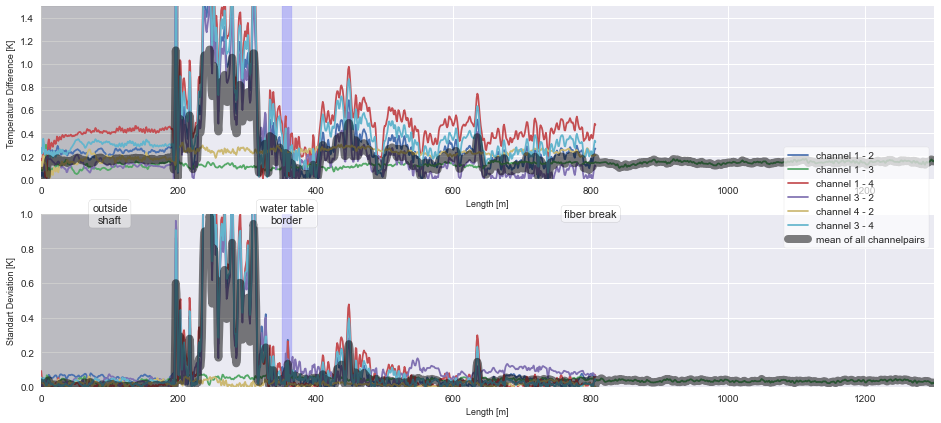

In [33]:
# Plot difference between figures of heatpump active and not active
mean_diff={}; std_diff={}
for chanpairkey in mean_constshift_heatpumpnotactive.keys(): #calc the difference
    mean_diff[chanpairkey]=abs(mean_constshift_heatpumpnotactive[chanpairkey] - mean_constshift_heatpumpactive[chanpairkey])
    std_diff[chanpairkey]=abs(std_constshift_heatpumpnotactive[chanpairkey] - std_constshift_heatpumpactive[chanpairkey])

plot_statistic_of_channel_difference(mean_diff, std_diff, "" ,ylim=[0,1.5], ax1ylim=[0,1],diff_plot=True)

if plot_save:
    if masterthesis_save:
        plt.savefig(r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\appendix\statistics_differences_constshift_diff_activenotactive_ch1-4.pdf", format="pdf",bbox_inches="tight")
        plt.savefig(r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\appendix_raster\statistics_differences_constshift_diff_activenotactive_ch1-4.png", format="png",bbox_inches="tight")
    plt.savefig(r".\pictures\statistics_differences_constshift_diff_activenotactive_ch1-4.png",bbox_inches="tight")
plt.show()